In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#데이터 sacling
from sklearn.preprocessing import StandardScaler

#데이터 분할
from sklearn.model_selection import train_test_split

#분류 NN(MLPClassifier)
from sklearn.neural_network import MLPClassifier

#confusion matrix
from sklearn.metrics import confusion_matrix

import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

In [2]:
matplotlib.rc('font', family = 'NanumGothic')

### step1. 데이터 구성하기

In [6]:
df_raw = pd.read_csv("/home/piai/test/Practice/data/HMEQ.csv", engine="python",encoding="EUC-KR")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


### - 결측치 제거

In [7]:
df_raw['JOB'].value_counts()
#결측치 대체 함수. 
#JOB 변수의 결측치는 other 로 대체
df_raw['JOB'].fillna('Other', inplace = True)

#숫자형 변수의 결측치는 해당 변수의 평균값 입력
df_raw.fillna(df_raw.mean(), inplace = True)
df_raw.isnull().sum(axis = 0)

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

In [8]:
#get_dummies : 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)

#더미변수 생성된 데이터의 상위5개 row 확인
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


### - 데이터 분할

In [9]:
#train_test_split (X : 설명변수 데이터, Y : 목표변수 데이터, test_size = test 데이터 비율, random_state : random seed)

#목표변수, 설명변수 데이터 지정
df_raw_y = df_raw_dummy['BAD']
df_raw_x = df_raw_dummy.drop('BAD', axis = 1 , inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size = 0.3, random_state = 1234)
print(f'train data X size :{df_train_x.shape}')
print(f'train data Y size :{df_train_y.shape}')
print(f'test data X size :{df_test_x.shape}')
print(f'test data Y size :{df_test_y.shape}')

train data X size :(2623, 18)
train data Y size :(2623,)
test data X size :(1125, 18)
test data Y size :(1125,)


### step2: MLPClassifier 모델 생성


In [10]:
#모델 생성
nn_uncustomized = MLPClassifier(random_state = 1234)
nn_uncustomized.fit(df_train_x, df_train_y)

#train 데이터 셋 정확도
print('Accuracy on training set : {:.3f}'.format(nn_uncustomized.score(df_train_x, df_train_y)))

#test 데이터 셋 정확도
print('Accuracy on test set : {:.3f}'.format(nn_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set : 0.722
Accuracy on test set : 0.683


In [11]:
nn_uncustomized

MLPClassifier(random_state=1234)

### MLPClassifier 모델 parameter 변경

### - Hidden layer : 은닉층 변경

In [12]:
#train 및 test 설명력 결과 저장
train_accuracy = []
test_accuracy = []

#hidden_layer_sizes : 은닉층 노드 수 변경 (20,40,60,80,100,120,140,160)
para_hidden= [hidden * 20 for hidden in range(1,9)]
for v_hidden in para_hidden:
    nn = MLPClassifier(random_state = 1234 , 
             hidden_layer_sizes = v_hidden)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))
    
#결과 저장
df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden['HiddenLayer'] = para_hidden
df_accuracy_hidden['Trainaccuracy'] = train_accuracy
df_accuracy_hidden['Testaccuracy'] = test_accuracy
df_accuracy_hidden.round(3)

,HiddenLayer,Trainaccuracy,Testaccuracy
0,20,0.906,0.903
1,40,0.886,0.879
2,60,0.909,0.908
3,80,0.910,0.909
4,100,0.722,0.683
5,120,0.909,0.908
6,140,0.213,0.193
7,160,0.907,0.907


### - Hidden layer : 은닉층 변경도 결과 

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


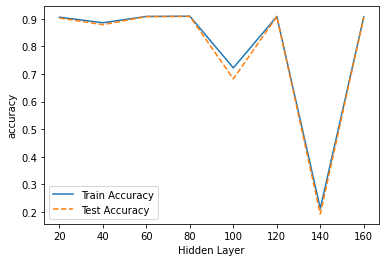

In [13]:
#모델 설명력 그래프 확인
plt.plot(para_hidden, train_accuracy, linestyle = "-", label = 'Train Accuracy')
plt.plot(para_hidden, test_accuracy, linestyle = "--", label = 'Test Accuracy')
plt.xlabel('Hidden Layer')
plt.ylabel('accuracy')
plt.legend()

### - Activation: 활성화 함수 변경

In [14]:
#train 및 test 설명력 결과 저장
train_accuracy = []
test_accuracy = []

#activation 변경
para_function = ['logistic','tanh','relu']

for v_function in para_function:
    nn = MLPClassifier(random_state = 1234 , 
             activation = v_function)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))
    
#결과 저장
df_accuracy_function = pd.DataFrame()
df_accuracy_function['ActivationFunction'] = para_function
df_accuracy_function['Trainaccuracy'] = train_accuracy
df_accuracy_function['Testaccuracy'] = test_accuracy
df_accuracy_function.round(3)

,ActivationFunction,Trainaccuracy,Testaccuracy
0,logistic,0.908,0.908
1,tanh,0.908,0.908
2,relu,0.722,0.683


### - Activation: 활성화 함수 변경 결과

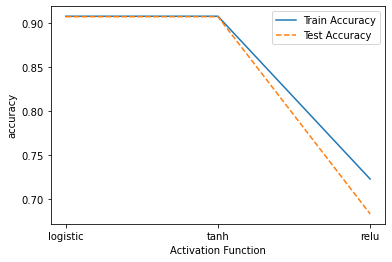

In [15]:
#모델 설명력 그래프 확인
plt.plot(para_function, train_accuracy, linestyle = "-", label = 'Train Accuracy')
plt.plot(para_function, test_accuracy, linestyle = "--", label = 'Test Accuracy')
plt.xlabel('Activation Function')
plt.ylabel('accuracy')
plt.legend()

### - Standardscaler: 설명변수 scale 변경


In [16]:
#scale 변환 - Standardscaler: 설명변수 scale 변경
#변수명 저장
v_feature_name = df_train_x.columns
#StandardScaler 적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns=v_feature_name)
df_scaled.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
2,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556
3,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,-1.548549,1.548549,2.618672,-0.446497,-0.828257,-0.574064,-0.131804,-0.189556
4,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556


In [17]:
#데이터 분할
df_scaled_train_x, df_scaled_test_x = train_test_split(df_scaled, test_size=0.3, random_state = 1234)
print('train data X size: {}'.format(df_scaled_train_x.shape))
print('test data X size: {}'.format(df_scaled_test_x.shape))

train data X size: (2623, 18)
test data X size: (1125, 18)


### scale 조절 후 MLPClassifier 모델 재실행
### - scale 이 조정된 데이터로 새로운 모델 생성

In [18]:

#scale 조절 후 MLPClassifier 모델 재실행 - scale이 조정된 데이터로 새로운 모델 생성
nn_scaled = MLPClassifier(random_state=1234)
nn_scaled.fit(df_scaled_train_x, df_train_y)
#train 데이터 셋 정확도
print('Accuracy on training set: {:.3f}'.format(nn_scaled.score(df_scaled_train_x, df_train_y)))
print('Accuracy on test set: {:.3f}'.format(nn_scaled.score(df_scaled_test_x, df_test_y)))

Accuracy on training set: 0.971
Accuracy on test set: 0.943


/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### - Hidden Layer: 은닉층 변경

In [19]:
#train 및 test 설명력 결과 저장
train_accuracy = []
test_accuracy = []

#hidden_layer_sizes : 은닉층 변경 (20~240, by 30)
para_hidden= [20 * hidden for hidden in range(1,11)]

for v_hidden in para_hidden:
    nn = MLPClassifier(random_state = 1234 , 
             hidden_layer_sizes = (v_hidden,v_hidden))
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
#결과 저장
df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden['HiddenLayer'] = para_hidden
df_accuracy_hidden['Trainaccuracy'] = train_accuracy
df_accuracy_hidden['Testaccuracy'] = test_accuracy
df_accuracy_hidden.round(3)

/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages

,HiddenLayer,Trainaccuracy,Testaccuracy
0,20,0.975,0.948
1,40,0.994,0.952
2,60,0.999,0.949
3,80,1.000,0.955
4,100,1.000,0.953
5,120,1.000,0.951
6,140,1.000,0.955
7,160,1.000,0.955
8,180,1.000,0.957
9,200,1.000,0.956


### - Hidden Layer: 은닉층 변경 결과

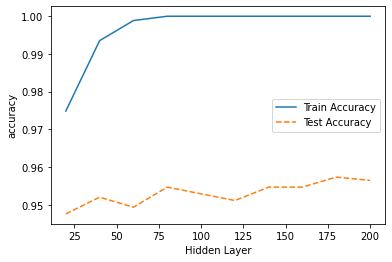

In [20]:
#모델 설명력 그래프 확인
plt.plot(para_hidden, train_accuracy, linestyle = "-", label = 'Train Accuracy')
plt.plot(para_hidden, test_accuracy, linestyle = "--", label = 'Test Accuracy')
plt.xlabel('Hidden Layer')
plt.ylabel('accuracy')
plt.legend()

In [21]:
#은닉층 지정(임의)
hidden_layer_sizes = 80

### - Activation: 활성화 함수 변경

In [22]:
# train 및 test 정확도 결과 저장용
train_accuracy=[]; test_accuracy=[]
#activation 변경
para_function=["logistic","tanh","relu"]
for v_function in para_function:
    nn=MLPClassifier(activation=v_function, hidden_layer_sizes=(80,80), random_state=1234)
    nn.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x,df_test_y))
# 데이터 테이블로 저장
df_accuracy_function=pd.DataFrame()
df_accuracy_function['MinSamplesSplit']= para_function
df_accuracy_function['TrainAccuracy']=train_accuracy
df_accuracy_function['TestAccuracy']=test_accuracy
# Activation function별 정확도 테이블
df_accuracy_function.round(3)

/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,logistic,0.937,0.933
1,tanh,0.999,0.952
2,relu,1.000,0.955


### - Activation: 활성화 함수 변경 결과

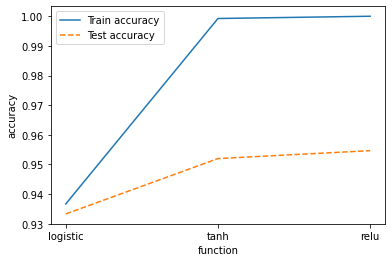

In [23]:
# Activation function별 정확도 그래프 확인
plt.plot(para_function,train_accuracy,linestyle='-',label='Train accuracy')
plt.plot(para_function,test_accuracy,linestyle='--',label='Test accuracy')
plt.ylabel('accuracy')
plt.xlabel('function')
plt.legend()
# Activation Function 지정(임의)
activation='relu'

In [24]:
#Activation Function 지정 (임의)
activation = 'relu'

### - Solver: 가중치 최적화 변경

In [25]:
# train 및 test 정확도 결과 저장용
train_accuracy=[]
test_accuracy=[]
# solver 변경
para_solver=['lbfgs','sgd','adam']
for v_solver in para_solver:
    nn=MLPClassifier(solver=v_solver,activation='relu',hidden_layer_sizes=(80,80),random_state=1234)
    nn.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x,df_test_y))
# 데이터 테이블로 저장
df_accuracy_solver=pd.DataFrame()
df_accuracy_solver['Estimators']=para_solver
df_accuracy_solver['TrainScore']=train_accuracy
df_accuracy_solver['TestScore']=test_accuracy
# Solver별 정확도 테이블
df_accuracy_solver.round(3)

/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Estimators,TrainScore,TestScore
0,lbfgs,1.000,0.948
1,sgd,0.934,0.928
2,adam,1.000,0.955


### - Solver: 가중치 최적화 변경 결과

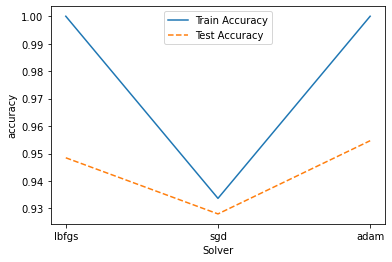

In [26]:
# 정확도 그래프 표현
plt.plot(para_solver,train_accuracy,linestyle='-',label='Train Accuracy')
plt.plot(para_solver,test_accuracy,linestyle='--',label='Test Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Solver')
plt.legend()

In [27]:
#Solver 지정(임의)
solver = 'adam'

### - mini batch 변경

In [28]:
# train 및 test정확도 결과 저장용
train_accuracy = []
test_accuracy = []
# Mini Batch 변경 :
para_batch = [20 * batch for batch in range(1,10)]
for v_batch in para_batch:
    nn = MLPClassifier(batch_size = v_batch, solver = "adam", activation="relu", hidden_layer_sizes = (80,80), random_state = 1234)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
df_accuracy_batch = pd.DataFrame()
df_accuracy_batch["Mini Batch"] = para_batch
df_accuracy_batch["TrainAccuracy"] = train_accuracy
df_accuracy_batch["TestAccuracy"] = test_accuracy
df_accuracy_batch.round(3)

/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Mini Batch,TrainAccuracy,TestAccuracy
0,20,1.0,0.959
1,40,1.0,0.956
2,60,1.0,0.950
3,80,1.0,0.952
4,100,1.0,0.952
5,120,1.0,0.953
6,140,1.0,0.953
7,160,1.0,0.954
8,180,1.0,0.956


### - mini batch 변경 결과

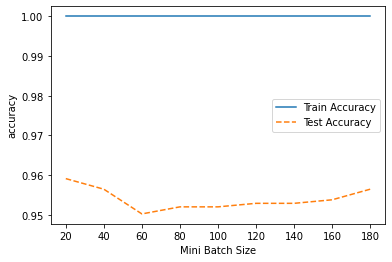

In [29]:
# 정확도 그래프 표현
plt.plot(para_batch, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_batch, test_accuracy, linestyle="--", label="Test Accuracy")
plt.ylabel("accuracy")
plt.xlabel("Mini Batch Size")
plt.legend()

### step3: 결론 도출
### - 최종 모델 선택

In [30]:
#최종모델
nn_final = MLPClassifier(hidden_layer_sizes = (80,80), activation = 'relu', solver = 'adam', 
                batch_size =100 , random_state = 1234)
nn_final.fit(df_scaled_train_x, df_train_y)

#평가
y_pred = nn_final.predict(df_scaled_test_x)

#train 데이터 셋 정확도
print('Accuracy on training set : {:3f}'.format(nn_final.score(df_scaled_train_x, df_train_y)))

#test 데이터 셋 정확도
print('Accuracy on test set : {:3f}'.format(nn_final.score(df_scaled_test_x, df_test_y)))

#confusion matrix
print('Confusion matrix: \n {}'.format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set : 1.000000
Accuracy on test set : 0.952000
Confusion matrix: 
 [[1018    3]
 [  51   53]]
